<a href="https://colab.research.google.com/github/joomj2000/SKT_FLY_AI/blob/main/LSTM%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install finance-datareader


In [17]:
!pip show finance-datareader


Name: finance-datareader
Version: 0.9.90
Summary: Financial data reader (price, stock list of markets)
Home-page: https://github.com/financedata/financedatareader
Author: FinanceData.KR
Author-email: plusjune@financedata.kr
License: MIT License
Location: /usr/local/lib/python3.10/dist-packages
Requires: lxml, pandas, requests, requests-file, tqdm
Required-by: 


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import FinanceDataReader as fdr



In [82]:
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
sk=fdr.DataReader('066570')

In [83]:
sk['Year']=sk.index.year
sk['Month']=sk.index.month
sk['Day']=sk.index.day

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scale_cols=['Open','High','Low','Close','Volume']
scaled=scaler.fit_transform(sk[scale_cols])


In [85]:
df=pd.DataFrame(scaled,columns=scale_cols)

In [86]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df.drop('Close',axis=1),df['Close'],test_size=0.2,random_state=0,shuffle=False)


In [87]:
x_train.shape, y_train.shape

((4388, 4), (4388,))

In [88]:
x_train

,Open,High,Low,Volume
0,0.168839,0.207920,0.185347,0.364920
1,0.202603,0.192942,0.196439,0.237844
2,0.186037,0.180961,0.169026,0.204549
3,0.157371,0.154596,0.152712,0.170310
4,0.136979,0.152199,0.142922,0.182381
...,...,...,...,...
4383,0.243101,0.227449,0.256741,0.018186
4384,0.245057,0.242164,0.262752,0.040251
4385,0.255488,0.245843,0.272769,0.022647
4386,0.262007,0.245843,0.274772,0.010823


In [89]:
import tensorflow as tf

In [90]:
def windowed_dataset(series, window_size, batch_size, shuffle):
  series = tf.expand_dims(series, axis=-1)
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds=ds.flat_map(lambda w :w.batch(window_size + 1)) # 잘라온 데이터를 window_size +1만큼 가져옴
  if shuffle: #셔플이 true이면 ds를 1000줌(랜덤성)
    ds=ds.shuffle(1000)
  ds=ds.map(lambda w: (w[:-1], w[-1:])) #읽어온 애를 기준으로 처음부터 맨끝까지 읽어오기
  return ds.batch(batch_size).prefetch(1)

In [91]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [92]:
train_data=windowed_dataset(y_train,WINDOW_SIZE,BATCH_SIZE,True)
test_data=windowed_dataset(y_test,WINDOW_SIZE,BATCH_SIZE,False)

In [93]:
for data in train_data.take(1):
  print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
  print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')


데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1, 1)


In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Conv1D,Lambda,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint



model=Sequential([
    Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[WINDOW_SIZE,1]), #LSTM의 featurn뽑으려고?
    LSTM(64,return_sequences=True),
    LSTM(64, activation='tanh'),
    Dense(16,activation='relu'),
    Dense(1)
])

In [95]:
# Sequence 학습에 좋은 Huber사용
from tensorflow.keras.losses import Huber
loss = Huber()
optimizer=Adam(0.001)
model.compile(loss=Huber(),optimizer=optimizer,metrics=['mse'])

In [96]:
# earlystopping 은
earlystopping=EarlyStopping(monitor='val_loss',patience=10)
# val_loss 기준 체크포인터도 생성함
filename=os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint=ModelCheckpoint(filename,save_weights_only=True,save_best_only=True,monitor='val_loss',verbose=1)



In [97]:
history=model.fit(train_data,epochs=50,validation_data=test_data,callbacks=[earlystopping,checkpoint])

Epoch 1/50
    136/Unknown - 8s 25ms/step - loss: 0.0010 - mse: 0.0020
Epoch 1: val_loss improved from inf to 0.00084, saving model to tmp/ckeckpointer.ckpt
137/137 [==============================] - 10s 44ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 8.4369e-04 - val_mse: 0.0017
Epoch 2/50
135/137 [============================>.] - ETA: 0s - loss: 3.5884e-04 - mse: 7.1768e-04
Epoch 2: val_loss improved from 0.00084 to 0.00067, saving model to tmp/ckeckpointer.ckpt
137/137 [==============================] - 4s 27ms/step - loss: 3.5746e-04 - mse: 7.1492e-04 - val_loss: 6.6959e-04 - val_mse: 0.0013
Epoch 3/50
136/137 [============================>.] - ETA: 0s - loss: 2.6895e-04 - mse: 5.3791e-04
Epoch 3: val_loss improved from 0.00067 to 0.00054, saving model to tmp/ckeckpointer.ckpt
137/137 [==============================] - 4s 26ms/step - loss: 2.6854e-04 - mse: 5.3708e-04 - val_loss: 5.4154e-04 - val_mse: 0.0011
Epoch 4/50
137/137 [==============================] - ETA: 0s - loss: 

In [98]:
model.load_weights(filename)

In [99]:
pred=model.predict(test_data)

34/34 [==============================] - 1s 10ms/step


In [100]:
pred.shape

(1078, 1)

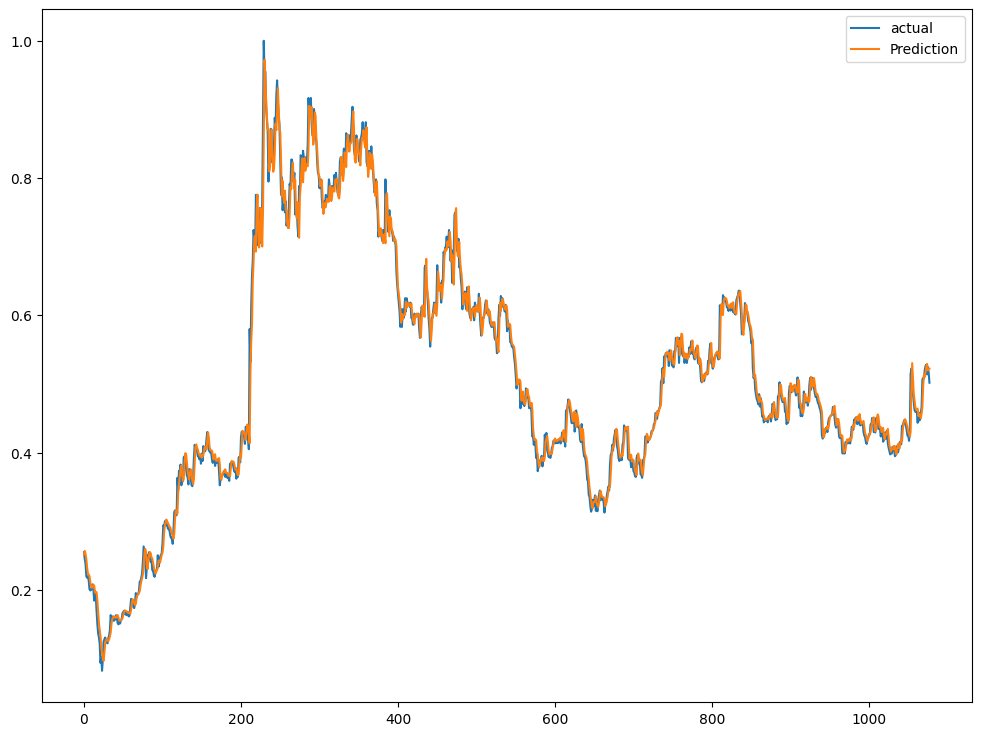

In [101]:
plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test)[20:],label='actual')
plt.plot(pred,label='Prediction')
plt.legend()
plt.show()